In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os


In [ ]:
tf.config.set_visible_devices([], 'GPU')  # Désactive le GPU


In [20]:
def print_current_device():
    # Obtenir tous les devices disponibles
    devices = tf.config.list_physical_devices()
    print("Devices disponibles:", devices)
    
    # Vérifier le device actuel
    current_device = tf.config.get_visible_devices()
    print("Device actuel:", current_device)
    
    # Vérifier si un GPU est utilisé
    if tf.test.is_built_with_cuda():
        print("TensorFlow est configuré avec CUDA")
    
   # Vérifier les devices visibles (actifs)
    visible_gpus = tf.config.get_visible_devices('GPU')
    if len(visible_gpus) > 0:
        print("GPU/Metal est disponible et activé")
    else:
        print("CPU est utilisé")

print_current_device()

Devices disponibles: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Device actuel: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
CPU est utilisé


In [4]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [5]:
# load the dataset
path = os.path.join('..', '..', 'datasets', 'airline-passengers.csv')
dataframe = pd.read_csv(path, usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')


In [6]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [7]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [8]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [9]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [10]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [11]:
# create LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

/Users/antoine/Documents/GitHub/AntoineMaes/Hardware-for-AI/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
# Train the model
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
94/94 - 1s - 6ms/step - loss: 0.0521
Epoch 2/100
94/94 - 0s - 589us/step - loss: 0.0264
Epoch 3/100
94/94 - 0s - 569us/step - loss: 0.0191
Epoch 4/100
94/94 - 0s - 541us/step - loss: 0.0171
Epoch 5/100
94/94 - 0s - 538us/step - loss: 0.0159
Epoch 6/100
94/94 - 0s - 850us/step - loss: 0.0149
Epoch 7/100
94/94 - 0s - 518us/step - loss: 0.0140
Epoch 8/100
94/94 - 0s - 528us/step - loss: 0.0130
Epoch 9/100
94/94 - 0s - 536us/step - loss: 0.0120
Epoch 10/100
94/94 - 0s - 550us/step - loss: 0.0111
Epoch 11/100
94/94 - 0s - 551us/step - loss: 0.0101
Epoch 12/100
94/94 - 0s - 526us/step - loss: 0.0092
Epoch 13/100
94/94 - 0s - 553us/step - loss: 0.0083
Epoch 14/100
94/94 - 0s - 525us/step - loss: 0.0074
Epoch 15/100
94/94 - 0s - 535us/step - loss: 0.0066
Epoch 16/100
94/94 - 0s - 539us/step - loss: 0.0058
Epoch 17/100
94/94 - 0s - 536us/step - loss: 0.0051
Epoch 18/100
94/94 - 0s - 541us/step - loss: 0.0045
Epoch 19/100
94/94 - 0s - 519us/step - loss: 0.0039
Epoch 20/100
94/94 - 0s

In [13]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Train Score: 22.78 RMSE
Test Score: 50.00 RMSE


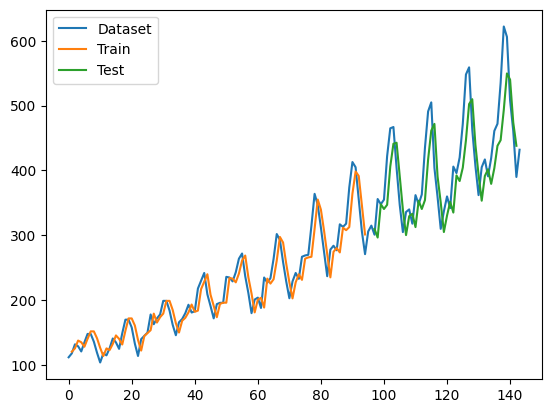

In [14]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label='Dataset')
plt.plot(trainPredictPlot, label='Train')
plt.plot(testPredictPlot, label='Test')
plt.legend()
plt.show()